# How the Human Brain Makes Sense of Natural Scenes
## Linearizing Encoding Model - Notebook

#### Import Libs

In [1]:
import os
import numpy as np
import math
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import matplotlib
from matplotlib import pyplot as plt
from nilearn import datasets
from nilearn import plotting
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torchvision import transforms
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from scipy.stats import pearsonr as corr

In [2]:
data_dir = 'nsd_data'
parent_submission_dir = 'submission_data'

In [3]:
device = 'cpu'
device = torch.device(device)

#### Select Subject (1-8):

In [4]:
subj = 1 # 1, 2, 3, 4, 5, 6, 7, 8

#### Define data paths

In [5]:
class argObj:
  def __init__(self, data_dir, parent_submission_dir, subj):
    
    self.subj = format(subj, '02')
    self.data_dir = os.path.join(data_dir, 'subj'+self.subj)
    self.parent_submission_dir = parent_submission_dir
    self.subject_submission_dir = os.path.join(self.parent_submission_dir,
        'subj'+self.subj)

    # Create the submission directory if not existing
    if not os.path.isdir(self.subject_submission_dir):
        os.makedirs(self.subject_submission_dir)

args = argObj(data_dir, parent_submission_dir, subj)

## Load fMRI training data

Load the training split of the fMRI data (from data_dir) for the selected subject (subj), for both hemispheres (LH/RH).

The files each contain a 2-dimensional array of the training stimulus images and corresponding fMRI veriticies.

In [6]:
fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

print('LH training fMRI data shape:')
print(lh_fmri.shape)
print('(Training stimulus images × LH vertices)\n')

print('RH training fMRI data shape:')
print(rh_fmri.shape)
print('(Training stimulus images × RH vertices)')

LH training fMRI data shape:
(9841, 19004)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(9841, 20544)
(Training stimulus images × RH vertices)


## fMRI ROIs

Reigons-of-interest (ROIs) divide the visual cortex into different local groups of vertices, performing similar functions. The files in the 'roi_masks' directory map brain ROIs to vertcies and vertices to fsaverage space, a standardized brain surface map for all subjects.

### Visualize all vertices on a brain surface map

Map all vertices, using the left and right ROI masks provided in the files '\*h.all-vertices_fsaverage_space.npy', to the indicies on the brain surface map in fsaverage space. We then output the graphical brain surface map highlighting the areas that represent the verticies mapped for all ROIs.

#### Select Hemisphere:

In [ ]:
hemisphere = 'left' # 'left', right'

#### Brain Surface Map

In [ ]:
# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)

# Create the interactive brain surface map
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')
view = plotting.view_surf(
    surf_mesh=fsaverage['infl_'+hemisphere],
    surf_map=fsaverage_all_vertices,
    bg_map=fsaverage['sulc_'+hemisphere],
    threshold=1e-14,
    cmap='cool',
    colorbar=False,
    title='All vertices, '+hemisphere+' hemisphere'
    )
view

### Visualize a chosen ROI on a brain surface map

Using the files '\*h.\*_fsaverage_space.npy' we map the vertices of several ROIs from a given class to the brain surface map in fsaverage space, then use the files mapping_\*.npy to select a specific ROI within the class to visualize on the brain surface map. 

#### Select Parameters

In [ ]:
hemisphere = 'left' # 'left', right'
roi = "EBA" #"V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"

#### Brain Surface Map

In [ ]:
# Define the ROI class based on the selected ROI
if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
    roi_class = 'prf-visualrois'
elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
    roi_class = 'floc-bodies'
elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
    roi_class = 'floc-faces'
elif roi in ["OPA", "PPA", "RSC"]:
    roi_class = 'floc-places'
elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
    roi_class = 'floc-words'
elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
    roi_class = 'streams'

# Load the ROI brain surface maps
roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_fsaverage_space.npy')
roi_map_dir = os.path.join(args.data_dir, 'roi_masks',
    'mapping_'+roi_class+'.npy')
fsaverage_roi_class = np.load(roi_class_dir)
roi_map = np.load(roi_map_dir, allow_pickle=True).item()

# Select the vertices corresponding to the ROI of interest
roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
fsaverage_roi = np.asarray(fsaverage_roi_class == roi_mapping, dtype=int)

# Create the interactive brain surface map
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')
view = plotting.view_surf(
    surf_mesh=fsaverage['infl_'+hemisphere],
    surf_map=fsaverage_roi,
    bg_map=fsaverage['sulc_'+hemisphere],
    threshold=1e-14,
    cmap='cool',
    colorbar=False,
    title=roi+', '+hemisphere+' hemisphere'
    )
view

## Stimulus images

Images of natural scenes come from the COCO dataset. https://cocodataset.org/#home

The images were pre-split into training and test partitions and correspond to the same training and test splits used for the fMRI data. The number of images within the training and test splits vary between subjects.

### Load stimulus imgaes

In [7]:
train_img_dir  = os.path.join(args.data_dir, 'training_split', 'training_images')
test_img_dir  = os.path.join(args.data_dir, 'test_split', 'test_images')

# Create lists will all training and test image file names, sorted
train_img_list = os.listdir(train_img_dir)
train_img_list.sort()
test_img_list = os.listdir(test_img_dir)
test_img_list.sort()
print('Training images: ' + str(len(train_img_list)))
print('Test images: ' + str(len(test_img_list)))

Training images: 9841
Test images: 159


## Visualize the fMRI responses to selected training images

### Map all vertices

#### Select Parameters:

In [ ]:
img = 42 #'0-[9841, 9841, 9082, 8779, 9841, 9082, 9841, 8779]' for each subject.
hemisphere = 'left' # 'left', right'

#### Brain Surface Map

In [ ]:
# Load the image
img_dir = os.path.join(train_img_dir, train_img_list[img])
train_img = Image.open(img_dir).convert('RGB')

# Plot the image
plt.figure()
plt.axis('off')
plt.imshow(train_img)
plt.title('Training image: ' + str(img+1));


# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)

# Map the fMRI data onto the brain surface map
fsaverage_response = np.zeros(len(fsaverage_all_vertices))
if hemisphere == 'left':
    fsaverage_response[np.where(fsaverage_all_vertices)[0]] = lh_fmri[img]
elif hemisphere == 'right':
    fsaverage_response[np.where(fsaverage_all_vertices)[0]] = rh_fmri[img]

# Create the interactive brain surface map
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')
view = plotting.view_surf(
    surf_mesh=fsaverage['infl_'+hemisphere],
    surf_map=fsaverage_response,
    bg_map=fsaverage['sulc_'+hemisphere],
    threshold=1e-14,
    cmap='cold_hot',
    colorbar=True,
    title='All vertices, '+hemisphere+' hemisphere'
    )
view

### Map for chosen individual ROI

#### Select ROI:

In [ ]:
roi = "lateral" #"V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"

#### Brain Surface Map

In [ ]:
# Plot the image
plt.figure()
plt.axis('off')
plt.imshow(train_img)
plt.title('Training image: ' + str(img+1));

# Define the ROI class based on the selected ROI
if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
    roi_class = 'prf-visualrois'
elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
    roi_class = 'floc-bodies'
elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
    roi_class = 'floc-faces'
elif roi in ["OPA", "PPA", "RSC"]:
    roi_class = 'floc-places'
elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
    roi_class = 'floc-words'
elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
    roi_class = 'streams'

# Load the ROI brain surface maps
challenge_roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_challenge_space.npy')
fsaverage_roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_fsaverage_space.npy')
roi_map_dir = os.path.join(args.data_dir, 'roi_masks',
    'mapping_'+roi_class+'.npy')
challenge_roi_class = np.load(challenge_roi_class_dir)
fsaverage_roi_class = np.load(fsaverage_roi_class_dir)
roi_map = np.load(roi_map_dir, allow_pickle=True).item()

# Select the vertices corresponding to the ROI of interest
roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
challenge_roi = np.asarray(challenge_roi_class == roi_mapping, dtype=int)
fsaverage_roi = np.asarray(fsaverage_roi_class == roi_mapping, dtype=int)

# Map the fMRI data onto the brain surface map
fsaverage_response = np.zeros(len(fsaverage_roi))
if hemisphere == 'left':
    fsaverage_response[np.where(fsaverage_roi)[0]] = \
        lh_fmri[img,np.where(challenge_roi)[0]]
elif hemisphere == 'right':
    fsaverage_response[np.where(fsaverage_roi)[0]] = \
        rh_fmri[img,np.where(challenge_roi)[0]]

# Create the interactive brain surface map
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')
view = plotting.view_surf(
    surf_mesh=fsaverage['infl_'+hemisphere],
    surf_map=fsaverage_response,
    bg_map=fsaverage['sulc_'+hemisphere],
    threshold=1e-14,
    cmap='cold_hot',
    colorbar=True,
    title=roi+', '+hemisphere+' hemisphere'
    )
view

## Building the Linearizing Encoding models

Taking the training data that we have loaded and visualized, we can now begin pre-processing it before training and fitting our regression models on it.

We first need to split the available data into training and validation partitions to allow for model performance evaluation after fitting our models. Normally we would use one of sklearn's cross-validation method implementations that provide built in functionality for splitting the data before training and validating the model. However, our training data consists of both stimulus images and their corresponding fMRI responses, also requiring unique pre-processing, (extracting and downsampling image features). Therefore we define a series of functions to; pre-process the images; create a data structure to store them;   randomly select a given proportion (10%) of image indicies for validation, and use the selected indexes to retrieve the relevant fMRI data, before repeating with a different random seed and therefore image indicies for each fold. We then average the evaluation (correlation) scores from each fold to give a final cross-validated average score for each hemisphere (LH, RH).

We first define the transform to be applied to the images prior to inputting them to AlexNet. We use a standard preprocessing pipeline, synonymous with typical/common computer vision preprocessing, for formatting the images for optimal feature extraction by the CNN.

In [8]:
transform = transforms.Compose([
    transforms.Resize((224,224)), # resize the images to 224x24 pixels
    transforms.ToTensor(), # convert the images to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize the images color channels
])

Next we define a custom implementation of the ImageDataset class from PyTorch, for storing the images from each partition before passing them to AlexNet, where each image is loaded and pretranformed before being returned to be used for feature extraction.

In [9]:
class ImageDataset(Dataset):
    def __init__(self, imgs_paths, idxs, transform):
        self.imgs_paths = np.array(imgs_paths)[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.imgs_paths[idx]
        img = Image.open(img_path).convert('RGB')
        # Preprocess the image and send it to the chosen device ('cpu')
        if self.transform:
            img = self.transform(img).to(device)
        return img

We then load the pre-trained AlexNet model, selecting the feature extraction layer which we wish to use for training our model on. 

In [10]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet')
model.to(device) # send the model to the chosen device ('cpu')
model.eval() # set the model to evaluation mode, since we are not training it

#train_nodes, _ = get_graph_node_names(model)
#print(train_nodes)

Using cache found in C:\Users\Foof/.cache\torch\hub\pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### Select feature layer: 

In [11]:
model_layer = "features.5" #["features.2", "features.5", "features.7", "features.9", "features.12", "classifier.2", "classifier.5", "classifier.6"] {allow-input: true}
feature_extractor = create_feature_extractor(model, return_nodes=[model_layer])

The feature layer from AlexNet is very large, so we downsample the output using the dimensionality reduction technique, Principal Component Analysis (PCA). The below method is used to fit the PCA on the training images features, and then downsample the training, validation and test images features.

'IncrementalPCA()' is used to partially fit the pca on the images in batches, saving memory as jupyter notebook has RAM limitations. 

In [12]:
def fit_pca(feature_extractor, dataloader):

    # Define PCA parameters
    pca = IncrementalPCA(n_components=100, batch_size=300)

    # Fit PCA to batch
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Fit PCA to batch
        pca.partial_fit(ft.detach().cpu().numpy())
    return pca

extract_features() then takes the outputs of the above methods and cells as parameters, (feature_extractor for extracting image features from chosen 'model_layer', 'dataloader' containing 'ImageDataset' for extraction, and 'pca' for downsampling extracted features), returning the downsampled imaged features from AlexNet.

In [13]:
def extract_features(feature_extractor, dataloader, pca):

    features = []
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Apply PCA transform
        ft = pca.transform(ft.cpu().detach().numpy())
        features.append(ft)
    return np.vstack(features)

### Cross-validation

We now perform the cross-validation. This involves setting (incrementing) the random seed and then splitting the training data. The images corresponding to the indexes selected for each partition are then loaded into the relevant ImageDataset using the DataLoader class (also from PyTorch).

In [14]:
def cross_validation(model_parameters, folds):
    lh_correlation_arrays = []
    rh_correlation_arrays = []

    for i in range (folds):
        rand_seed = i
        np.random.seed(rand_seed)

        # Calculate how many stimulus images correspond to 90% of the training data
        num_train = int(np.round(len(train_img_list) / 100 * 90))
        # Shuffle all training stimulus images
        idxs = np.arange(len(train_img_list))
        np.random.shuffle(idxs)
        # Assign 90% of the shuffled stimulus images to the training partition,
        # and 10% to the validation partition
        idxs_train, idxs_val = idxs[:num_train], idxs[num_train:]

        if i == 0:
            print('Training stimulus images: ' + format(len(idxs_train)))
            print('\nValidation stimulus images: ' + format(len(idxs_val)))

        batch_size = 300
        # Get the paths of all image files
        train_imgs_paths = sorted(list(Path(train_img_dir).iterdir()))
        test_imgs_paths = sorted(list(Path(test_img_dir).iterdir()))

        # The DataLoaders contain the ImageDataset class
        train_imgs_dataloader = DataLoader(
            ImageDataset(train_imgs_paths, idxs_train, transform), 
            batch_size=batch_size
        )
        val_imgs_dataloader = DataLoader(
            ImageDataset(train_imgs_paths, idxs_val, transform), 
            batch_size=batch_size
        )

        lh_fmri_train = lh_fmri[idxs_train]
        lh_fmri_val = lh_fmri[idxs_val]
        rh_fmri_train = rh_fmri[idxs_train]
        rh_fmri_val = rh_fmri[idxs_val]

        pca = fit_pca(feature_extractor, train_imgs_dataloader)

        features_train = extract_features(feature_extractor, train_imgs_dataloader, pca)
        features_val = extract_features(feature_extractor, val_imgs_dataloader, pca)

        # Fit linear regressions on the training data
        if(model_parameters[0] == "default"):
            reg_lh = LinearRegression().fit(features_train, lh_fmri_train)
            reg_rh = LinearRegression().fit(features_train, rh_fmri_train)
        elif(model_parameters[0] == "Lasso"):
            reg_lh = Lasso(alpha = model_parameters[1]).fit(features_train, lh_fmri_train)
            reg_rh = Lasso(alpha = model_parameters[1]).fit(features_train, rh_fmri_train)
        elif(model_parameters[0] == "Ridge"):
            reg_lh = Ridge(alpha = model_parameters[1]).fit(features_train, lh_fmri_train)
            reg_lh = Ridge(alpha = model_parameters[1]).fit(features_train, rh_fmri_train)
        # Use fitted linear regressions to predict the validation fMRI data
        lh_fmri_val_pred = reg_lh.predict(features_val)
        rh_fmri_val_pred = reg_rh.predict(features_val)

        # Empty correlation array of shape: (LH vertices)
        lh_correlation = np.zeros(lh_fmri_val_pred.shape[1])
        # Correlate each predicted LH vertex with the corresponding ground truth vertex
        for v in tqdm(range(lh_fmri_val_pred.shape[1])):
            lh_correlation[v] = corr(lh_fmri_val_pred[:,v], lh_fmri_val[:,v])[0]
        lh_correlation_arrays.append(lh_correlation)

        # Empty correlation array of shape: (RH vertices)
        rh_correlation = np.zeros(rh_fmri_val_pred.shape[1])
        # Correlate each predicted RH vertex with the corresponding ground truth vertex
        for v in tqdm(range(rh_fmri_val_pred.shape[1])):
            rh_correlation[v] = corr(rh_fmri_val_pred[:,v], rh_fmri_val[:,v])[0]
        rh_correlation_arrays.append(rh_correlation)

    lh_average_correlation = []    
    rh_average_correlation = []

    for i in range(len(lh_correlation_arrays[0])):
        lh_num = 0
        rh_num = 0
        for j in range (len(lh_correlation_arrays)):
            lh_num += lh_correlation_arrays[j][i];
            rh_num += rh_correlation_arrays[j][i];
        lh_average_correlation.append(lh_num / len(lh_correlation_arrays));
        rh_average_correlation.append(rh_num / len(rh_correlation_arrays));
        
    return lh_average_correlation, rh_average_correlation

For standard 'cross_validation()' with default parameters, each fold takes ~5 mins to fully execute. This is due to the overhead of extracting features and fitting the PCA on the current train-validation splits every fold. While this improves the accuracy of the image features used for training, it significantly slows down runtime.

Therefore we implement a 'fast_cross_validation()' method used for hyperparameter tuning, where we extract and downsample features for all images prior, (storing the full image 'features' set as a global variable). Each fold then simply randomly selects the 'idxs' (using a new random seed) and uses them to partition the 'features' into 'features_train' and 'features_val', and each hemisphere's, '*h_fmri' vertex responses into '*h_fmri_train' and '*h_fmri_val'.\
We then just repeat the same process of fitting the model (using 'model_parameters') and predicting fMRI responses, evaluating the predictions agasint the unseen ground truth fMRI data from the validation partition. We then return an array of the average correlation scores for each vertex across all the cross validation folds. 

In [15]:
def fast_cross_validation(model_parameters, folds):
    num_train = int(np.round(len(train_img_list) / 100 * 90))
    
    lh_correlation_arrays = []
    rh_correlation_arrays = []
    
    for i in tqdm(range(folds)):
        rand_seed = i
        np.random.seed(rand_seed)
        
        idxs = np.arange(len(train_img_list))
        np.random.shuffle(idxs)
        idxs_train, idxs_val = idxs[:num_train], idxs[num_train:]

        features_train = features[idxs_train] 
        features_val = features[idxs_val]

        lh_fmri_train = lh_fmri[idxs_train]
        lh_fmri_val = lh_fmri[idxs_val]
        rh_fmri_train = rh_fmri[idxs_train]
        rh_fmri_val = rh_fmri[idxs_val]

        # Fit linear regressions on the training data
        if(model_parameters[0] == "default"):
            reg_lh = LinearRegression().fit(features_train, lh_fmri_train)
            reg_rh = LinearRegression().fit(features_train, rh_fmri_train)
        elif(model_parameters[0] == "Lasso"):
            reg_lh = Lasso(alpha = model_parameters[1]).fit(features_train, lh_fmri_train)
            reg_rh = Lasso(alpha = model_parameters[1]).fit(features_train, rh_fmri_train)
        elif(model_parameters[0] == "Ridge"):
            reg_lh = Ridge(alpha = 1 - model_parameters[1]).fit(features_train, lh_fmri_train)
            reg_rh = Ridge(alpha = 1 - model_parameters[1]).fit(features_train, rh_fmri_train)
            # Use fitted linear regressions to predict the validation fMRI data
        lh_fmri_val_pred = reg_lh.predict(features_val)
        rh_fmri_val_pred = reg_rh.predict(features_val)

        # Empty correlation array of shape: (LH vertices)
        lh_correlation = np.zeros(lh_fmri_val_pred.shape[1])
        # Correlate each predicted LH vertex with the corresponding ground truth vertex
        for v in range(lh_fmri_val_pred.shape[1]):
            c = corr(lh_fmri_val_pred[:,v], lh_fmri_val[:,v])[0]
            if math.isnan(c) == True:
                lh_correlation[v] = 0
            else:
                lh_correlation[v] = c
        lh_correlation_arrays.append(lh_correlation)

        # Empty correlation array of shape: (RH vertices)
        rh_correlation = np.zeros(rh_fmri_val_pred.shape[1])
        # Correlate each predicted RH vertex with the corresponding ground truth vertex
        for v in range(rh_fmri_val_pred.shape[1]):
            c = corr(rh_fmri_val_pred[:,v], rh_fmri_val[:,v])[0]
            if math.isnan(c) == True:
                rh_correlation[v] = 0
            else:
                rh_correlation[v] = c
        rh_correlation_arrays.append(rh_correlation)

    lh_average_correlation = []    
    rh_average_correlation = []

    for i in range(len(lh_correlation_arrays[0])):
        lh_num = 0
        rh_num = 0
        for j in range (len(lh_correlation_arrays)):
            lh_num += lh_correlation_arrays[j][i];
            rh_num += rh_correlation_arrays[j][i];
        lh_average_correlation.append(lh_num / len(lh_correlation_arrays));
        rh_average_correlation.append(rh_num / len(rh_correlation_arrays));
        
    return lh_average_correlation, rh_average_correlation

cross_val_scores() calls either full or fast cross_validation() and calculates and outputs the median noise-normalized correlation (MNNC) score using the returned arrays of the average correlation scores for each vertex.

In [16]:
def cross_val_scores(fast, params, folds):
    if(fast == True):
        lh_score, rh_score = fast_cross_validation(params,folds)
    else:
        lh_score, rh_score = cross_validation(params,folds)

    print('\nLH correlation for all verticies: ')
    print(" [ ", lh_score[1], ",", lh_score[2], ",", lh_score[3], ", ... ]")

    result = []
    for i in range (0,len(lh_score)):
        result.append((lh_score[i]*lh_score[i])/0.36)   
    print("LH median noise-normalized score: ")
    print(np.median(result))

    print('\nRH correlation for all verticies: ')
    print(" [ ", rh_score[1], ",", rh_score[2], ",", rh_score[3], ", ... ]")

    result = []
    for i in range (0,len(rh_score)):
        result.append((rh_score[i]*rh_score[i])/0.36)
    print("RH median noise-normalized score: ")
    print(np.median(result))
    
    return lh_score, rh_score

#### Select parameters:

In [ ]:
fast = False # True, False
folds = 10 # 3, 5, 10

#### Cross-validate default linear regression model

NOTE: Runtime ~40 mins

In [ ]:
params = ["default",0]
lh_score, rh_score = cross_val_scores(fast, params, folds)

### Visualize averaged correlation score from cross-validation

We map the average correlations for each vertex (lh_score and rh_score), outputted from cross-validating our default Linear Regression model against 10 folds with different train-validation splits, to the brain surface map in fsaverage space. This is the same process as used for mapping and visualizing the fMRI data, with spatial heatmaps used to represent individual vertex's encoding accuracies across the visual cortex.

#### Select parameters:

In [ ]:
hemisphere = 'left' # 'left', 'right'

#### Brain Surface Map

In [ ]:
# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)

# Map the correlation results onto the brain surface map
fsaverage_correlation = np.zeros(len(fsaverage_all_vertices))
if hemisphere == 'left':
    fsaverage_correlation[np.where(fsaverage_all_vertices)[0]] = lh_score
elif hemisphere == 'right':
    fsaverage_correlation[np.where(fsaverage_all_vertices)[0]] = rh_score

# Create the interactive brain surface map
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')
view = plotting.view_surf(
    surf_mesh=fsaverage['infl_'+hemisphere],
    surf_map=fsaverage_correlation,
    bg_map=fsaverage['sulc_'+hemisphere],
    threshold=1e-14,
    cmap='cold_hot',
    colorbar=True,
    title='Encoding accuracy, '+hemisphere+' hemisphere'
    )
view

### Hyperparameter Tuning

By utilising the implemented fast_cross_validation method above, we can test model encoding accuracy for a variety of different models and parameters and compare their median noise-normalized correlation (MNNC) score.

As explained, we first must extract and downsample the image features of all the available training images prior to cross-validating and hyperparameter tuning our models.

In [17]:
idxs_train = np.arange(len(train_img_list))
train_imgs_paths = sorted(list(Path(train_img_dir).iterdir()))
batch_size = 300    
    
all_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_train, transform),
    batch_size=batch_size)

pca = fit_pca(feature_extractor, all_imgs_dataloader)

features = extract_features(feature_extractor, all_imgs_dataloader, pca)

print('\nAll images features:')
print(features.shape)
print('(Training stimulus images × PCA features)')

100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [01:34<00:00,  2.86s/it]


All images features:
(9841, 100)
(Training stimulus images × PCA features)


hyperparameter_tuning() then makes the calls to fast_cross_validation, slightly altering the hyperparameters used for training the model each time. We then take the models with maximum lh and rh MNNC scores and output them along with the parameters used. Linear Regression doesn't have any tuneable hyperparameters, but Lasso and Ridge regression have a regularization, alpha parameter, so we test and tune these linear regression variant models.

We find (as expected) L1 typically performs better closer to 0, while L2 performs better closer to 1. Therefore when selecting parameters, we start from '0+increment' and increment up for Lasso and from 1 and decrement down for Ridge.

In [ ]:
def hyperparameter_tuning(variant, increment, folds, num_models):
    lh_scores = []
    rh_scores = []

    for i in tqdm(range(num_models)):
        if variant == "Lasso":
            params = [variant, (i+1)*increment]
        elif variant == "Ridge":
            params = [variant, i*increment]
        else:
            print("Error: Invalid 'variant'")
            break
        lh_score, rh_score = fast_cross_validation(params,folds)
        
        result = []
        for i in range (0,len(lh_score)):
            result.append((lh_score[i]*lh_score[i])/0.36)
        lh_scores.append(np.median(result))
        
        result = []
        for i in range (0,len(rh_score)):
            result.append((rh_score[i]*rh_score[i])/0.36)
        rh_scores.append(np.median(result))
    
    if variant == "Lasso":
        best_lh_param = ((lh_scores.index(max(lh_scores)) + 1) * increment)
        best_lh_score = max(lh_scores)
        best_rh_param = ((rh_scores.index(max(rh_scores)) + 1) * increment)
        best_rh_score = max(rh_scores)
    elif variant == "Ridge":
        best_lh_param = 1 - ((lh_scores.index(max(lh_scores))) * increment)
        best_lh_score = max(lh_scores)
        best_rh_param = 1 - ((rh_scores.index(max(rh_scores))) * increment)
        best_rh_score = max(rh_scores)
        
    return best_lh_param, best_lh_score, best_rh_param, best_rh_score, lh_scores, rh_scores

#### Hyperparameter Optimization

We first tested both lasso and ridge regression with a broad range of regularization weights (0.05 - 1) and moderately large step size (0.05), using only a small number of folds. [folds = 3, increment = 0.05, num_models = 20] \
This resulted in:
    
    Lasso regression:
    Best Parameter (lh): 0.05
    Score:  0.11247963764930473
    Best Parameter (rh): 0.05
    Score:  0.10392108784850543
    
    Ridge regression: 
    Best Parameter (lh):  1.0
    Score:  0.14351039164289292
    Best Parameter (rh):  1.0
    Score:  0.13891029081283374
    
The below cell then shows the focused hyperparameter optimization. [folds = 10, increment = 0.005, num_models = 16] \
(NOTE: runtime ~9.5 hours! Therefore code has been commented out to allow running the entire notebook in a reasonable timeframe.)

(Sample output shown below)

#### Select Parameters: 

In [ ]:
folds = 10
increment = 0.005
num_models = 16

In [ ]:
"""
lasso_lh_param, lasso_lh_score, lasso_rh_param, lasso_rh_score, lasso_lh_scores, lasso_rh_scores = hyperparameter_tuning("Lasso",increment,folds,num_models)
print("Lasso regression: ")
print("\nBest Parameter (lh): ", lasso_lh_param)
print("Score: ", lasso_lh_score)
print("Best Parameter (rh): ", lasso_rh_param)
print("Score: ", lasso_rh_score)

ridge_lh_param, ridge_lh_score, ridge_rh_param, ridge_rh_score, ridge_lh_scores, ridge_rh_scores = hyperparameter_tuning("Ridge",increment,folds,num_models)
print("\nRidge regression: ")
print("\nBest Parameter (lh): ", ridge_lh_param)
print("Score: ", ridge_lh_score)
print("Best Parameter (rh): ", ridge_rh_param)
print("Score: ", ridge_rh_score)
"""

    100%|██████████████████████████████████████████████████████████████████| 10/10 [31:56<00:00, 191.66s/it]\
    100%|██████████████████████████████████████████████████████████████████| 16/16 [9:20:39<00:00, 2102.47s/it]

    Lasso regression:
    Best Parameter (lh): 0.005
    Score:  0.14594120099705177
    Best Parameter (rh): 0.005
    Score:  0.14113831049905573

    ...

    100%|██████████████████████████████████████████████████████████████████| 10/10 [00:56<00:00, 5.62s/it]\
    100%|██████████████████████████████████████████████████████████████████| 16/16 [16:54<00:00, 63.39s/it]

    Ridge regression: 
    Best Parameter (lh):  1.0
    Score:  0.14351039164289292
    Best Parameter (rh):  1.0
    Score:  0.13891029081283374

Finally, we check the 2 model parameters either side, L1=0.004 and 0.006, verifying if 0.005 is the best regularization weight.

    fast = True
    params = ["Lasso",0.004]
    folds = 10
    lh_score, rh_score = cross_val_scores(fast,params,folds)

    fast = True
    params = ["Lasso",0.006]
    folds = 10
    lh_score, rh_score = cross_val_scores(fast,params,folds)

We find that 0.005 is in fact the best alpha value.

#### Optimally performing model: Lasso

#### Parameters: L1 (alpha) regularizer = 0.005
(10 fold cv) averaged MNNC Score from both hemispheres = 0.14353975574

In [18]:
fast = True
params = ["Lasso",0.005]
folds = 10
lh_score, rh_score = cross_val_scores(fast,params,folds)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [32:57<00:00, 197.80s/it]



LH correlation for all verticies: 
 [  0.19101201176443852 , 0.31309371126328445 , 0.6552992758367835 , ... ]
LH median noise-normalized score: 
0.14117485344493055

RH correlation for all verticies: 
 [  0.07816308614796288 , 0.24204477765786817 , 0.19740231811612213 , ... ]
RH median noise-normalized score: 
0.13696698708030686


### Visualize final model encoding accuracy

Now that we have found and cross-validated our model with the optimal hyperparamters, we have an estimate of our best and final model's expected performance for predicting the unseen test data. We can visualize this evaluation by mapping the average correlation scores, obtained from cross-validation, for each vertex in fsaverage space, comparing the model with default parameters against our final model with tuned hyperparameters. We also show each individual ROI encoding accuracy, allowing visual (side-by-side) comparisons.

#### Select Parameters:

In [ ]:
hemisphere = 'left' # 'left', 'right'

#### Brain Surface Map

In [ ]:
# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)

# Map the correlation results onto the brain surface map
fsaverage_correlation = np.zeros(len(fsaverage_all_vertices))
if hemisphere == 'left':
    fsaverage_correlation[np.where(fsaverage_all_vertices)[0]] = lh_score
elif hemisphere == 'right':
    fsaverage_correlation[np.where(fsaverage_all_vertices)[0]] = rh_score

# Create the interactive brain surface map
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')
view = plotting.view_surf(
    surf_mesh=fsaverage['infl_'+hemisphere],
    surf_map=fsaverage_correlation,
    bg_map=fsaverage['sulc_'+hemisphere],
    threshold=1e-14,
    cmap='cold_hot',
    colorbar=True,
    title='Encoding accuracy, '+hemisphere+' hemisphere'
    )
view

#### ROI Bar Chart Plots

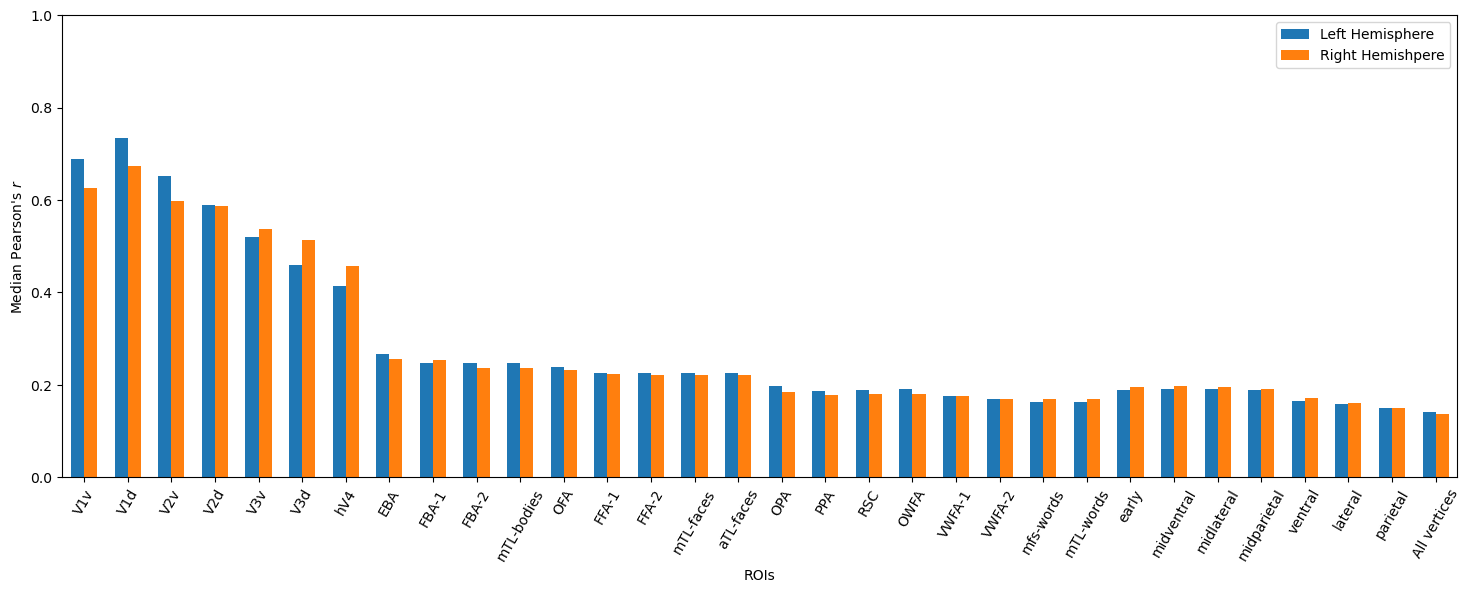

In [23]:
# Load the ROI classes mapping dictionaries
roi_mapping_files = ['mapping_prf-visualrois.npy', 'mapping_floc-bodies.npy',
    'mapping_floc-faces.npy', 'mapping_floc-places.npy',
    'mapping_floc-words.npy', 'mapping_streams.npy']
roi_name_maps = []
for r in roi_mapping_files:
    roi_name_maps.append(np.load(os.path.join(args.data_dir, 'roi_masks', r),
        allow_pickle=True).item())

# Load the ROI brain surface maps
lh_challenge_roi_files = ['lh.prf-visualrois_challenge_space.npy',
    'lh.floc-bodies_challenge_space.npy', 'lh.floc-faces_challenge_space.npy',
    'lh.floc-places_challenge_space.npy', 'lh.floc-words_challenge_space.npy',
    'lh.streams_challenge_space.npy']
rh_challenge_roi_files = ['rh.prf-visualrois_challenge_space.npy',
    'rh.floc-bodies_challenge_space.npy', 'rh.floc-faces_challenge_space.npy',
    'rh.floc-places_challenge_space.npy', 'rh.floc-words_challenge_space.npy',
    'rh.streams_challenge_space.npy']
lh_challenge_rois = []
rh_challenge_rois = []
for r in range(len(lh_challenge_roi_files)):
    lh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        lh_challenge_roi_files[r])))
    rh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        rh_challenge_roi_files[r])))

# Select the correlation results vertices of each ROI
roi_names = []
lh_roi_correlation = []
rh_roi_correlation = []
lh_median_roi_correlation = []
rh_median_roi_correlation = []
for r1 in range(len(lh_challenge_rois)):
    for r2 in roi_name_maps[r1].items():
        if r2[0] != 0: # zeros indicate to vertices falling outside the ROI of interest
            roi_names.append(r2[1])
            lh_roi_idx = np.where(lh_challenge_rois[r1] == r2[0])[0]
            rh_roi_idx = np.where(rh_challenge_rois[r1] == r2[0])[0]
            for i in range(len(lh_roi_idx)):
                lh_roi_correlation.append(lh_score[lh_roi_idx[i]])    
            result = []
            for i in range(len(lh_roi_correlation)):
                result.append((lh_roi_correlation[i]*lh_roi_correlation[i])/0.36)
            lh_median_roi_correlation.append(np.median(result))

            for i in range(len(rh_roi_idx)):
                if rh_roi_idx[i] < len(rh_score):
                    rh_roi_correlation.append(rh_score[rh_roi_idx[i]])
            result = []
            for i in range(len(rh_roi_correlation)):
                result.append((rh_roi_correlation[i]*rh_roi_correlation[i])/0.36)
            rh_median_roi_correlation.append(np.median(result))
                
roi_names.append('All vertices')
result = []
for i in range(len(lh_score)):
    result.append((lh_score[i]*lh_score[i])/0.36)
lh_median_roi_correlation.append(np.median(result))
result = []
for i in range(len(rh_score)):
    result.append((rh_score[i]*rh_score[i])/0.36)
rh_median_roi_correlation.append(np.median(result))

# Create the plot
plt.figure(figsize=(18,6))
x = np.arange(len(roi_names))
width = 0.30
plt.bar(x - width/2, lh_median_roi_correlation, width, label='Left Hemisphere')
plt.bar(x + width/2, rh_median_roi_correlation, width, label='Right Hemishpere')
plt.xlim(left=min(x)-.5, right=max(x)+.5)
plt.ylim(bottom=0, top=1)
plt.xlabel('ROIs')
plt.xticks(ticks=x, labels=roi_names, rotation=60)
plt.ylabel('Median Pearson\'s $r$')
plt.legend(frameon=True, loc=1);

#### Challenge submission output

In [32]:
print(median_roi_correlations[31])
print(len(roi_names))

13.162264926933004
32


In [42]:
subj1_lh = [46.32442556548531,51.08899535730035,34.74474194621837,35.13296329951969,34.529909074937756,32.70454755204716,31.879209840229887,8.819160647966452,9.035400230406326,0.0,0.0,21.31974451406929,12.135629492098248,0.0,0.0,0.0,11.522314969769402,5.924183088309226,9.432102612021394,22.936554308145194,7.404689027663874,12.997731891615855,6.631992126455625,0.0,35.903425798917084,31.52761481364178,18.84578616374288,16.991288437313955,9.501386980842414,8.600013328550151,8.195007572463926,14.435286253732418]
subj1_rh = [52.87531145556122,46.54993206269225,33.63158460341151,35.49565170632978,31.872098600517884,31.79538286088375,27.19352424831004,9.6588525449478,27.618828385908245,7.789180040300314,0.0,14.526487265472662,8.674202115983881,8.288030228397748,0.0,0.0,8.314631804665567,8.685918420840558,8.49931781161948,20.683861507960813,8.196774714435746,4.3505822778748575,0.0,0.0,34.715512222000186,26.10352396060909,10.364659493601465,9.09053811431248,10.081515464650742,9.034452398427781,4.213422055326263,12.770907902220948]

subj2_lh = [45.332894038065525,50.00597120411122,37.83930528747408,31.344810817295375,32.986758607340185,32.872716811029825,32.077809282001425,9.489507136093724,0.0,6.705536024392753,0.0,19.76840878731198,14.769169812340117,4.993062114904662,0.0,0.0,13.262380751662851,14.455038747475268,11.358748267519838,20.758811352877878,9.067172928130075,1.0729380887078168,9.754344553052766,0.0,32.895585166819906,28.32512231383295,22.32503544117622,18.497510630167525,10.9463159881192,8.870832935192771,9.631195791745014,14.257213652479251]
subj2_rh = [47.1278722936599,52.315315309177,30.986887761143382,27.40920340883946,28.12205430607101,30.563065563586363,24.285044835437084,9.707945198575576,0.0,6.936682209784038,0.0,16.379677521849032,13.377697408836257,7.227155680475608,0.0,0.0,8.507314761088223,11.387410278842294,13.374879284218128,17.30196171798552,5.759493884754509,7.9235056361056735,6.359504007453518,0.0,33.52892138105319,22.500635957221583,19.26969610354142,17.28232952664865,9.428297651601495,10.290184187046215,5.964389606569026,13.480738531262162]

subj3_lh = [48.91498365391469,40.30362671476867,41.9906254089971,32.09623616486783,36.53434488543118,29.092491083610817,25.34527829988673,15.748501361793101,7.468103120296447,18.8594120798264,0.0,18.813322084100285,25.798998394423723,18.58886413714953,0.0,0.0,14.926513421938962,12.464976023367173,10.516780809157984,24.93711859783828,6.749344069705051,2.327914835802728,13.545423850021201,0.0,36.302089702439304,31.838560685422618,19.6786833626845,19.0675222305342,13.190113275405611,13.39608806054285,12.107171405697802,17.694910872051487]
subj3_rh = [44.07694668812665,48.46013156792711,30.52987027320792,37.61541451466307,25.827429552567345,36.71584794357235,26.455443627969988,15.360960234194337,14.090335784459768,22.26054454287956,0.0,20.099013607417525,21.435729907974647,17.706681641524323,0.0,0.0,11.17474870103597,13.052652502969512,12.164683101197882,16.202234537429746,11.90935473950639,0.0,0.0,0.0,33.16701326796802,24.97972940067397,19.538738553165064,23.570365463535996,14.74935366281597,15.701976677816798,12.01996345361439,17.5552800247039581]

subj4_lh = [44.10892050493664,40.02854027855114,31.852478113774723,42.01593897842794,22.545776487573782,27.73824704323569,18.400397789798784,7.557558081210926,0.0,4.212653891048049,0.0,11.438334064449911,10.084265313097058,4.397444549996146,0.0,0.0,10.671864314273773,11.555232852610994,4.982032179701285,8.618206307758111,12.221118757162902,1.753801266252601,9.471449786482356,0.0,28.764039120404007,18.291178107865363,10.636364777475684,16.252338732571346,10.509112656919466,5.889577953444175,8.487690452122543,12.237171583725676]
subj4_rh = [46.85873110205343,39.523333448127964,41.22236724768205,32.017373928390995,31.82839391903863,24.37089244082049,25.173649076300723,8.686145988343242,19.243762086842043,17.642941565347222,0.0,13.195665889251913,11.07761204845895,10.611630089722329,0.0,0.0,11.072592031417429,10.660594461846976,4.777551165619639,12.024358605718104,11.913684806416452,0.0,10.038431798621911,0.0,30.93607367320248,16.545676771842178,12.523529864847525,23.050558460464682,12.099415934773216,6.88722748922309,4.834922645387815,12.90928908635771]

subj5_lh = [46.062587676117936,46.38539824056406,43.35919641289771,40.0500048156124,25.212260287141564,24.595768532919422,18.812735380073185,9.236146183652998,11.315151597922874,7.692297011552267,0.0,13.578647070037885,9.140566369459787,9.421461440807802,0.0,0.0,16.774088761677937,17.20598795535668,12.421660098545868,14.58199111460603,6.1833762441504225,6.418870954723752,4.424467801964725,0.0,34.309305782109874,19.240063926657005,13.134927005476511,17.971997940963917,12.157588310794715,9.461263102001261,9.842485354198647,14.593022871485228]
subj5_rh = [52.359538290560415,47.411872745304365,35.32823234331202,28.588670090142195,20.81512207155707,23.43365782040148,17.08452522929499,8.651384718784712,7.8309459369744525,7.4487121191910255,0.0,14.520605462406625,7.125062669573116,9.967275935308274,0.0,0.0,15.789538999853075,17.172433029434167,13.166692205162938,10.212298238451055,9.447221888766578,3.6627438492888276,6.304850181315406,0.0,27.90291394804339,16.063290653032738,7.304828407339832,18.85364792413992,11.335888595861311,8.713330180580755,12.055235663572393,13.420783531232917]

subj6_lh = [64.34528076525488,42.211364601182424,47.082833320574466,42.228798842062915,32.869613554209224,32.44324674977581,14.97810446476616,7.226722389497239,5.875747348411947,8.442066054077342,0.0,9.234009936771706,8.357258379297996,3.9217063057202917,0.0,0.0,7.35442902196081,13.720649264708623,15.814046465545525,8.943273837083455,5.41355814917001,4.88560982882986,9.722937484613631,0.0,31.5268393203908,9.894033707825873,7.786130494994942,6.845028640061565,8.670615482132632,7.163892856950559,4.034814349281109,10.14071289852497]
subj6_rh = [55.71040795785936,51.7577953212637,42.68142434044377,38.63721700127377,35.9216071645304,27.63515278531173,19.895202590921585,8.652311790840008,11.725338311293818,10.813536712318532,4.480600728708386,5.238852917368789,11.435151635331597,11.193774982077262,0.0,0.0,4.943519883214628,13.561937674670265,14.70971730806998,4.639654212599022,5.848843749359117,8.35725231448329,7.591702043982511,0.0,36.014967602457276,12.541532827198045,9.208824649707987,10.309725338534182,11.297506731245392,8.682729723401529,3.7037991550341154,11.506693115243465]

subj7_lh = [26.78037761435282,23.26030246054272,22.78526927459691,10.581955902580889,21.242501676619607,9.816653225745494,14.859818897385898,7.483051806011313,0.0,7.8419797377908065,0.0,10.973951954836162,16.243993349060894,11.728194545401267,0.0,0.0,13.558927363832861,13.672563537878643,5.437579370231974,9.218973290578262,21.378894039112332,5.880085501153315,9.039950927983455,0.0,18.42592388793871,16.237442075765138,5.396010123065588,19.1372031795791,11.511874874278117,7.946680948020945,8.284730467220784,11.453274914449686]
subj7_rh = [25.495078381374192,16.499916158431713,18.968474634596806,7.960695233394391,12.537324970866164,7.109011584351133,8.134140081941894,10.31839199778552,0.0,15.047145086472327,0.0,7.8784010283633545,16.67016400359504,0.49278554369556526,0.0,0.0,16.245446431889878,12.759794671620295,16.216130171729663,1.529632001969907,10.592937187970659,11.65562728964487,7.885252819582818,2.074356068300955,13.807787888667516,9.327391827800689,9.860489841010626,6.869297083749185,10.595742601107805,11.463285095368004,5.158556636816866,10.355964110600393]

subj8_lh = [48.69208541754186,41.569993125296264,37.10416204662951,31.025274182560945,29.01552531562101,28.92442199251142,29.322801120052315,6.514111343053046,5.048014259782356,10.321735951357939,0.0,18.848278706357185,16.322593194908485,14.673110627308214,0.0,0.0,7.946633840004479,7.894427029043493,4.448731377732475,23.994858297795833,5.675227571860127,6.258496265938493,7.469021939520716,0.0,29.892185616399054,28.659276375252915,9.920191436896308,7.35393048815753,9.749421823713154,5.837542032994057,5.963641173792086,11.206600294910146]
subj8_rh = [43.054874970088406,39.913825590926834,34.66642615056103,34.48796367320611,31.043407380347173,29.945623505150703,29.222451023211416,7.463769953161709,11.995242070611267,13.687604613169224,4.123030798544313,17.011538323393815,15.906008399384659,15.60590431082992,0.0,0.0,6.571284088537633,10.168601125189538,7.862665501638605,18.18540909033178,8.911696425668056,0.0,13.322134075324755,0.0,34.34117358168538,23.022803501470655,17.173315621012044,14.065247915186369,11.099655837714934,6.436861970054665,4.7751356268094245,12.842856328038247]

average_lh = []
average_rh = []

for i in range(len(subj1_lh)):
    result = (subj1_lh[i] + subj2_lh[i] + subj3_lh[i] + subj4_lh[i] + subj5_lh[i] + subj6_lh[i] + subj7_lh[i] + subj8_lh[i]) / 8
    average_lh.append(result)
    result = (subj1_rh[i] + subj2_rh[i] + subj3_rh[i] + subj4_rh[i] + subj5_rh[i] + subj6_rh[i] + subj7_rh[i] + subj8_rh[i]) / 8
    average_rh.append(result)
    
print(average_lh)
print(average_rh)

[46.32019440445871, 41.85677399778961, 37.094826476395355, 33.059497875366, 29.367086236109287, 27.273511623859452, 23.209519384274298, 9.00934486865985, 4.842802069602493, 8.009460093755695, 0.0, 15.4968371397418, 14.106559288085787, 8.465480465160988, 0.0, 0.0, 12.002144055640134, 12.111632312343763, 9.301460147557043, 16.74872338833538, 9.261672598369348, 5.199431079128052, 8.75744855876181, 0.0, 31.00242429942734, 23.001661500782955, 13.465391100689077, 15.264602534918643, 10.779553674025664, 8.395736402212096, 8.318342070815238, 13.252274167669857]
[45.94484514241044, 42.80401527548136, 33.501908419294814, 30.27652369452997, 27.24592974568696, 26.44607931300975, 22.180497589173463, 9.812470303329114, 11.5630565720112, 12.703293361182782, 1.0754539409065873, 13.606280251940465, 13.212703523642269, 10.136654801503877, 0.0, 0.0, 10.327384587712801, 12.181167770676701, 11.34645456865704, 12.597426239055743, 9.072500924609688, 4.49371392092469, 6.437734365785115, 0.2592945085376194, 30

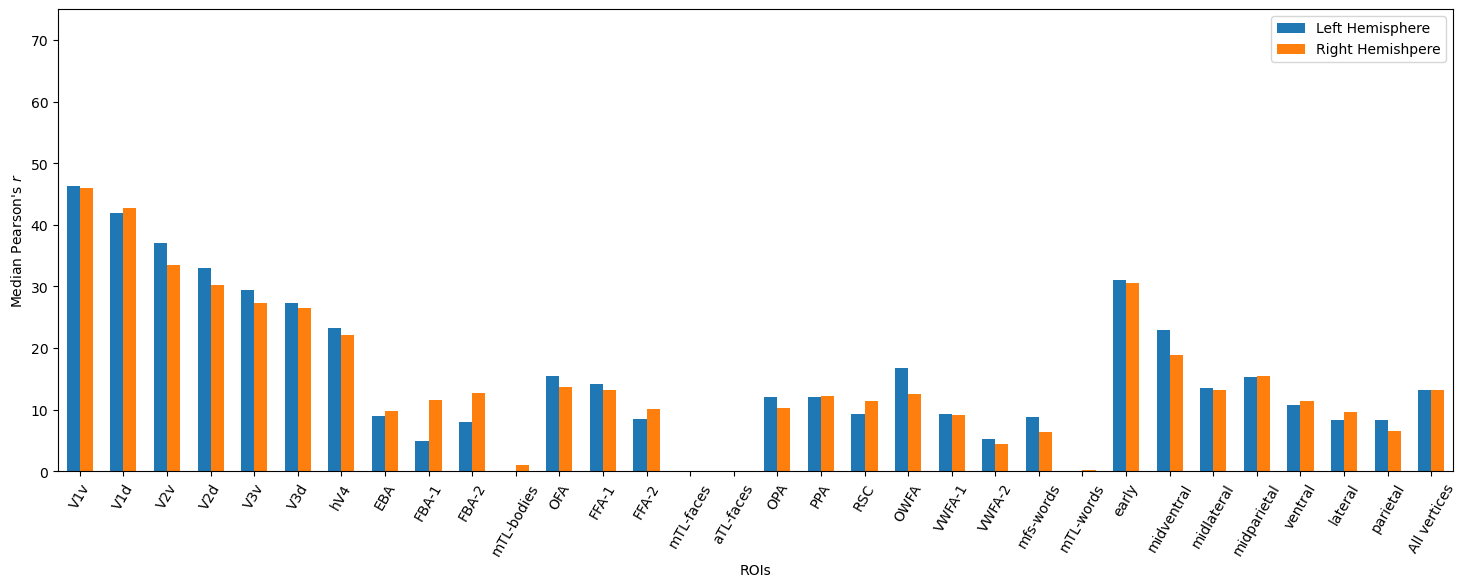

In [44]:
plt.figure(figsize=(18,6))
x = np.arange(len(roi_names))
width = 0.30
plt.bar(x - width/2, average_lh, width, label='Left Hemisphere')
plt.bar(x + width/2, average_rh, width, label='Right Hemishpere')
plt.xlim(left=min(x)-.5, right=max(x)+.5)
plt.ylim(bottom=0, top=75)
plt.xlabel('ROIs')
plt.xticks(ticks=x, labels=roi_names, rotation=60)
plt.ylabel('Median Pearson\'s $r$')
plt.legend(frameon=True, loc=1);

## Challenge submission

Finally, we train and fit the final model on all the available training data, originally supplied by the NSD dataset. This is the our best possible, validated, linear regression model, with optimised parameters and maximally trained feature weights for predicting fMRI repsonses to unseen visual stimuli. 

We then use our final model to output fMRI predictions for all verticies across all brain ROIs for all 8 subjects, before saving and submitting them through the offical Algonauts submission link. We are then given a ranking and challenge (MNNC) score for our model output.

In [ ]:
print(args.subject_submission_dir)

In [ ]:
idxs_train = np.arange(len(train_img_list))
train_imgs_paths = sorted(list(Path(train_img_dir).iterdir()))
idxs_test = np.arange(len(test_img_list))
test_imgs_paths = sorted(list(Path(test_img_dir).iterdir()))
batch_size=400

train_imgs_dataloader = DataLoader(
        ImageDataset(train_imgs_paths, idxs_train, transform), 
        batch_size=batch_size
    )
test_imgs_dataloader = DataLoader(
    ImageDataset(test_imgs_paths, idxs_test, transform), 
    batch_size=batch_size
)

lh_fmri_train = lh_fmri[idxs_train]
rh_fmri_train = rh_fmri[idxs_train]

del lh_fmri, rh_fmri

pca = fit_pca(feature_extractor, train_imgs_dataloader)

features_train = extract_features(feature_extractor, train_imgs_dataloader, pca)
features_test = extract_features(feature_extractor, test_imgs_dataloader, pca)

reg_lh = Lasso(alpha=0.005).fit(features_train, lh_fmri_train)
reg_rh = Lasso(alpha=0.005).fit(features_train, rh_fmri_train)

lh_fmri_test_pred = reg_lh.predict(features_test)
rh_fmri_test_pred = reg_rh.predict(features_test)

lh_fmri_test_pred = lh_fmri_test_pred.astype(np.float32)
rh_fmri_test_pred = rh_fmri_test_pred.astype(np.float32)

np.save(os.path.join(args.subject_submission_dir, 'lh_pred_test.npy'), lh_fmri_test_pred)
np.save(os.path.join(args.subject_submission_dir, 'rh_pred_test.npy'), rh_fmri_test_pred)

Rank:

Score: 